In [29]:
!pip install tensorflow
#Install Libraries

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, LeakyReLU, Dense, Dropout
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
import os
import shutil
from sklearn.model_selection import train_test_split
import time

In [30]:
# Menggunakan direktori lokal di Windows
import os
os.chdir(r"C:/Users/RY/Exp5/labelled")

In [5]:
#Load Dataset
dataset_path = 'C:/Users/RY/Exp5/labelled'
engaged_path = os.path.join(dataset_path, 'engaged')
disengaged_path = os.path.join(dataset_path, 'disengaged')

In [6]:
#Create folder for training and testing
output_path = 'C:/Users/RY/Exp5/dataset_split'
train_path = os.path.join(output_path, 'train')
test_path = os.path.join(output_path, 'test')

os.makedirs(os.path.join(train_path, 'engaged'), exist_ok=True)
os.makedirs(os.path.join(train_path, 'disengaged'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'engaged'), exist_ok=True)
os.makedirs(os.path.join(test_path, 'disengaged'), exist_ok=True)

In [8]:
#Split training and testing
def split_data(source, train_dest, test_dest, test_size=0.2):

  """
  Splits data into train and test sets and copies file to respective folders.
  Introduces a delay to mitigate potential I/O errors on Google Colab
  """
  for i in range(3): #retry up to 3x
    try:
      files = os.listdir(source)
      break #exit loop
    except OSError as e:
      if i < 2: #if not the last attempt
        print(f"Percobaan {i+1} gagal dengan error: {e}")
        print("Coba ulang setelah delay...")
        time.sleep(5) #tunggu 5 detik sblm cb lagi
      else: #klo percobaan terakhir gagal
        raise e #re-raise the exception

  train_files, test_files = train_test_split(files, test_size=test_size, random_state=42)

  # move files to folder train
  for file in train_files:
      shutil.copy(os.path.join(source, file), os.path.join(train_dest, file))

  # move files to folder test
  for file in test_files:
      shutil.copy(os.path.join(source, file), os.path.join(test_dest, file))

# split dataset
split_data(engaged_path, os.path.join(train_path, 'engaged'), os.path.join(test_path, 'engaged'))
split_data(disengaged_path, os.path.join(train_path, 'disengaged'), os.path.join(test_path, 'disengaged'))

In [31]:
#checking training n testing folder
train_path = "C:/Users/RY/Exp5/dataset_split/train"
test_path = "C:/Users/RY/Exp5/dataset_split/test"

In [32]:
#check random img
x = plt.imread("C:/Users/RY/Exp5/dataset_split/train/engaged/peserta8_9449.jpg")
x.shape

(180, 320, 3)

In [33]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [34]:
train = datagen.flow_from_directory(train_path,target_size=(48,48),class_mode="sparse", seed=1, color_mode="grayscale", batch_size=128)
test = datagen.flow_from_directory(test_path,target_size=(48,48),class_mode="sparse", seed=1, color_mode="grayscale", batch_size=128)

Found 50678 images belonging to 2 classes.
Found 12567 images belonging to 2 classes.


In [35]:
dir(train)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_api_export_path',
 '_api_export_symbol_id',
 '_filepaths',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_set_index_array',
 '_warn_if_super_not_called',
 'allowed_class_modes',
 'batch_index',
 'batch_size',
 'class_indices',
 'class_mode',
 'classes',
 'color_mode',
 'data_format',
 'directory',
 'dtype',
 'filenames',
 'filepaths',
 'image_data_generator',
 'image_shape',
 'index_array',
 'index_generator',
 'interpolation',
 'keep_aspect_ratio',
 'labels',
 'lock',
 'max_queue_size',
 'n',
 'num_batches',
 'num_classes',
 'on_epoch_be

In [36]:
print(train.class_indices)
emotion_dict = {0: "Engaged", 1: "Disengaged"}

{'disengaged': 0, 'engaged': 1}


In [37]:
# Use __next__() instead of next()
x, y = train.__next__()
print(x.shape, y.shape)
train.reset()

(128, 48, 48, 1) (128,)


In [38]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(48,48,1),padding="same"),
    LeakyReLU(),
    Conv2D(32, (3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64,(3,3),padding="same"),
    LeakyReLU(),
    Conv2D(64,(3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128,(3,3),padding="same"),
    LeakyReLU(),
    Conv2D(128,(3,3), padding="same"),
    LeakyReLU(),
    Conv2D(128,(3,3), padding="same"),
    LeakyReLU(),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
#     tf.keras.layers.GlobalAveragePooling2D(),
#     Dropout(0.4),

    Dense(128, activation='relu'),
    Dropout(0.4),
#     Dense(64, activation="relu"),

    Dense(len(train.class_indices), activation="softmax")
])
model.summary()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

C:\Users\RY\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)         │             320 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 48, 48, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)         │           9,248 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 48, 48, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)         │             128 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)         │          18,496 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 24, 24, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)         │          36,928 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 24, 24, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)         │             256 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)        │          73,856 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)        │         147,584 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)        │         147,584 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_2                │

 Total params: 1,025,122 (3.91 MB)

 Trainable params: 1,024,674 (3.91 MB)

 Non-trainable params: 448 (1.75 KB)

In [39]:
net = Sequential(name='DCNN')

net.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=(48, 48, 1),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_1'
    )
)
net.add(BatchNormalization(name='batchnorm_1'))
net.add(
    Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_2'
    )
)
net.add(BatchNormalization(name='batchnorm_2'))

net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
net.add(Dropout(0.4, name='dropout_1'))

net.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_3'
    )
)
net.add(BatchNormalization(name='batchnorm_3'))
net.add(
    Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_4'
    )
)
net.add(BatchNormalization(name='batchnorm_4'))

net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
net.add(Dropout(0.4, name='dropout_2'))

net.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_5'
    )
)
net.add(BatchNormalization(name='batchnorm_5'))
net.add(
    Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='elu',
        padding='same',
        kernel_initializer='he_normal',
        name='conv2d_6'
    )
)
net.add(BatchNormalization(name='batchnorm_6'))

net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
net.add(Dropout(0.5, name='dropout_3'))

net.add(Flatten(name='flatten'))

net.add(
    Dense(
        128,
        activation='elu',
        kernel_initializer='he_normal',
        name='dense_1'
    )
)
net.add(BatchNormalization(name='batchnorm_7'))

net.add(Dropout(0.6, name='dropout_4'))

net.add(
    Dense(
        7,
        activation='softmax',
        name='out_layer'
    )
)

net.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

net.summary()

Model: "DCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)         │           1,664 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_1 (BatchNormalization)     │ (None, 48, 48, 64)         │             256 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 48, 48, 64)         │         102,464 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_2 (BatchNormalization)     │ (None, 48, 48, 64)         │             256 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ maxpool2d_1 (MaxPooling2D)           │ (None, 24, 24, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 24, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 128)        │          73,856 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_3 (BatchNormalization)     │ (None, 24, 24, 128)        │             512 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 24, 24, 128)        │         147,584 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_4 (BatchNormalization)     │ (None, 24, 24, 128)        │             512 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ maxpool2d_2 (MaxPooling2D)           │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 256)        │         295,168 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_5 (BatchNormalization)     │ (None, 12, 12, 256)        │           1,024 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 256)        │         590,080 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_6 (BatchNormalization)     │ (None, 12, 12, 256)        │           1,024 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ maxpool2d_3 (MaxPooling2D)           │ (None, 6, 6, 256)          │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 6, 6, 256)          │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)               │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                │       1,179,776 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batchnorm_7 (BatchNormalization)     │ (None, 128)                │             512 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │

 Total params: 2,395,591 (9.14 MB)

 Trainable params: 2,393,543 (9.13 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [42]:
model.fit(train, validation_data=test, epochs=200, callbacks=callbacks)

C:\Users\RY\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 265s 638ms/step - accuracy: 0.7995 - loss: 0.5425 - val_accuracy: 0.3586 - val_loss: 1.1456 - learning_rate: 1.0000e-04
Epoch 2/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 233s 590ms/step - accuracy: 0.8626 - loss: 0.3571 - val_accuracy: 0.9043 - val_loss: 0.2513 - learning_rate: 1.0000e-04
Epoch 3/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 227s 573ms/step - accuracy: 0.8936 - loss: 0.2905 - val_accuracy: 0.9254 - val_loss: 0.2138 - learning_rate: 1.0000e-04
Epoch 4/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 230s 580ms/step - accuracy: 0.9063 - loss: 0.2600 - val_accuracy: 0.9310 - val_loss: 0.1945 - learning_rate: 1.0000e-04
Epoch 5/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 251s 634ms/step - accuracy: 0.9147 - loss: 0.2379 - val_accuracy: 0.9385 - val_loss: 0.1803 - learning_rate: 1.0000e-04
Epoch 6/200
396/396 ━━━━━━━━━━━━━━━━━━━━ 196s 495ms/step - accuracy: 0.9204 - loss: 0.2218 - val_accuracy: 0.9334 - val_loss: 0.1776 - learning_rate: 1.0000e-04
Epoch 7/200
396/396 ━━━━━━━━━━━━━━

In [43]:
model.save('modelbaselineawal.h5')

In [44]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 48, 48, 32)         │             320 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 48, 48, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 32)         │           9,248 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 48, 48, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 48, 48, 32)         │             128 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 24, 24, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 24, 24, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 24, 24, 64)         │          18,496 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 24, 24, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 24, 24, 64)         │          36,928 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 24, 24, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 24, 24, 64)         │             256 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 12, 12, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 12, 12, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 12, 12, 128)        │          73,856 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 128)        │         147,584 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 12, 12, 128)        │         147,584 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 12, 12, 128)        │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_2                │

 Total params: 3,074,472 (11.73 MB)

 Trainable params: 1,024,674 (3.91 MB)

 Non-trainable params: 448 (1.75 KB)

 Optimizer params: 2,049,350 (7.82 MB)

In [26]:
#install pydot to visualize model

!pip install pydot

In [37]:
#check if pydot installed correctly

import pydot
print("Pydot is installed and working!")

Pydot is installed and working!


In [34]:
pip install graphviz

Note: you may need to restart the kernel to use updated packages.


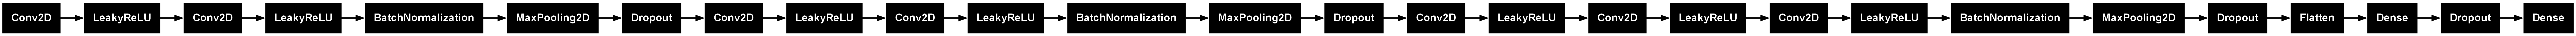

In [45]:
from tensorflow.keras.utils import plot_model


# Visualize the model
plot_model(model,to_file='my_model.png',show_shapes=False, rankdir="LR")

# Visualize the Model showing the input and output shapes
#plot_model(model,to_file='my_model.png',show_shapes=True)

In [46]:
# Replace `test.next()` with `next(test)`
x, y = next(test)
preds = model.predict(x)
idx = np.argmax(preds, axis=1)
print('correct prediction:', np.sum((y == idx) * 1) / 128)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
correct prediction: 0.9921875


In [47]:
preds = model.predict(x[:1])
np.argmax(preds, axis = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step


array([1], dtype=int64)

In [48]:
img = x[0]
res = np.array([img])

In [49]:
model.predict(res)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step


array([[3.6754261e-06, 9.9999630e-01]], dtype=float32)

In [50]:
print("y values (label sebenarnya):", y[:10])
print("Kategori y:", [emotion_dict[label] for label in y[:10]])

y values (label sebenarnya): [1. 1. 0. 0. 1. 1. 1. 1. 1. 0.]
Kategori y: ['Disengaged', 'Disengaged', 'Engaged', 'Engaged', 'Disengaged', 'Disengaged', 'Disengaged', 'Disengaged', 'Disengaged', 'Engaged']


In [51]:
print(train.class_indices)
emotion_dict = {1: "Engaged", 0: "Disengaged"}

{'disengaged': 0, 'engaged': 1}


In [52]:
print("y values (label sebenarnya):", y[:10])
print("Kategori y:", [emotion_dict[label] for label in y[:10]])

y values (label sebenarnya): [1. 1. 0. 0. 1. 1. 1. 1. 1. 0.]
Kategori y: ['Engaged', 'Engaged', 'Disengaged', 'Disengaged', 'Engaged', 'Engaged', 'Engaged', 'Engaged', 'Engaged', 'Disengaged']


In [53]:
print("idx values (prediksi model):", idx[:10])
print("Kategori idx:", [emotion_dict[pred] for pred in idx[:10]])

idx values (prediksi model): [1 1 0 0 1 1 1 1 1 0]
Kategori idx: ['Engaged', 'Engaged', 'Disengaged', 'Disengaged', 'Engaged', 'Engaged', 'Engaged', 'Engaged', 'Engaged', 'Disengaged']


In [54]:
for i in range(10):  # Lihat 10 sampel pertama
    print(f"Sample {i+1}: Label={emotion_dict[y[i]]}, Prediksi={emotion_dict[idx[i]]}")

Sample 1: Label=Engaged, Prediksi=Engaged
Sample 2: Label=Engaged, Prediksi=Engaged
Sample 3: Label=Disengaged, Prediksi=Disengaged
Sample 4: Label=Disengaged, Prediksi=Disengaged
Sample 5: Label=Engaged, Prediksi=Engaged
Sample 6: Label=Engaged, Prediksi=Engaged
Sample 7: Label=Engaged, Prediksi=Engaged
Sample 8: Label=Engaged, Prediksi=Engaged
Sample 9: Label=Engaged, Prediksi=Engaged
Sample 10: Label=Disengaged, Prediksi=Disengaged


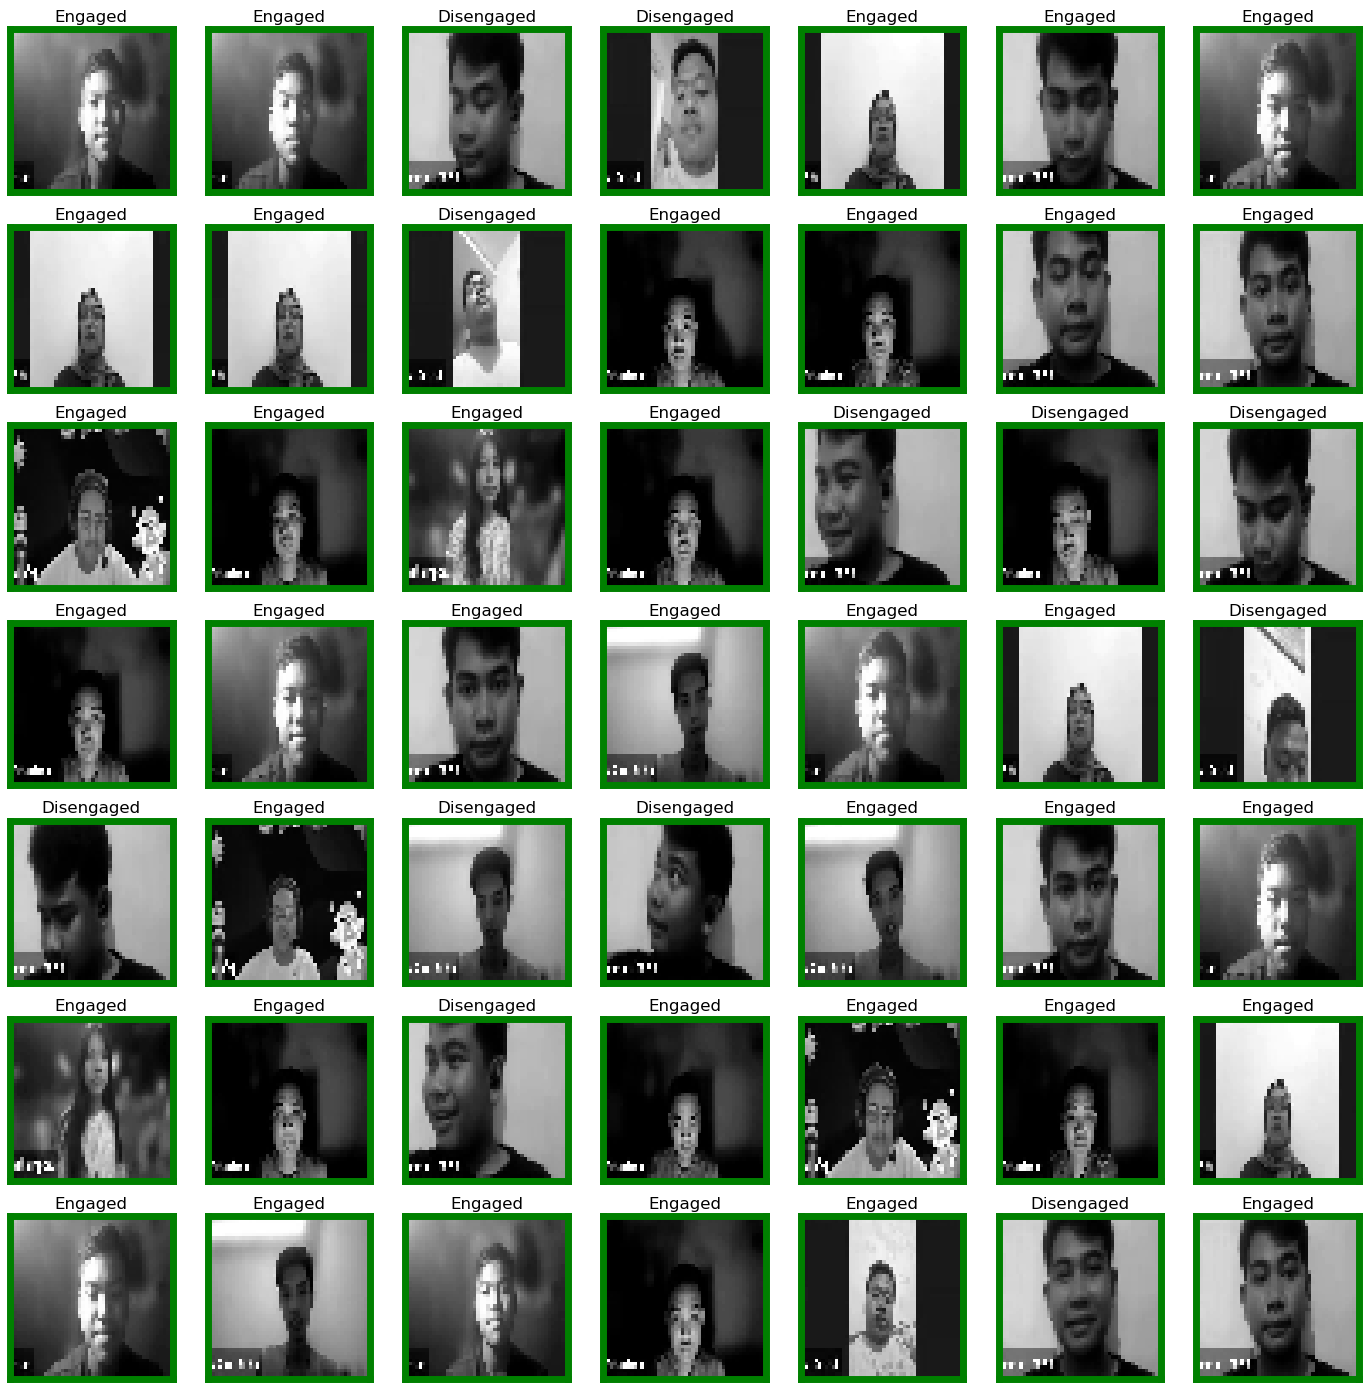

In [55]:
fig = plt.figure(1, (14, 14))

k = 0
# Batasi jumlah gambar yang ditampilkan menjadi maksimal 49
for j in range(min(len(x), 49)):  # Hanya tampilkan maksimal 49 gambar
    px = x[j]
    k += 1
    ax = plt.subplot(7, 7, k)  # Grid 7x7
    ax.imshow(px, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Cek apakah prediksi dan label benar
    if emotion_dict[y[j]] == emotion_dict[idx[j]]:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('green')  # Hijau jika prediksi benar
        ax.set_title(emotion_dict[idx[j]])
    else:
        for axis in ['top', 'bottom', 'left', 'right']:
            ax.spines[axis].set_linewidth(5)
            ax.spines[axis].set_color('red')  # Merah jika prediksi salah
        ax.set_title('P:' + emotion_dict[idx[j]] + " C:" + emotion_dict[y[j]])

plt.tight_layout()
plt.show()

In [56]:
# Import library untuk evaluasi
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# --- Persiapan Dataset Uji --- #
# Path folder uji
test_path_engaged = os.path.join(test_path, 'engaged')
test_path_disengaged = os.path.join(test_path, 'disengaged')

# Muat gambar dari direktori uji
def load_test_images_and_labels():
    X_test = []
    y_test = []

    # Load gambar dari folder engaged
    for img_name in os.listdir(test_path_engaged):
        img_path = os.path.join(test_path_engaged, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        X_test.append(img)
        y_test.append(1)  # Label untuk engaged

    # Load gambar dari folder disengaged
    for img_name in os.listdir(test_path_disengaged):
        img_path = os.path.join(test_path_disengaged, img_name)
        img = load_img(img_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        X_test.append(img)
        y_test.append(0)  # Label untuk disengaged

    return np.array(X_test), np.array(y_test)

# Panggil fungsi untuk mendapatkan X_test dan y_test
X_test, y_test = load_test_images_and_labels()

print(f"Jumlah data uji: {len(X_test)}")


Jumlah data uji: 12567


In [58]:
print(model.input_shape)

(None, 48, 48, 1)


In [59]:
print(X_test.shape)

(12567, 224, 224, 3)


In [60]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os
import numpy as np

# Path dataset uji
test_path_engaged = os.path.join(test_path, 'engaged')
test_path_disengaged = os.path.join(test_path, 'disengaged')

# Fungsi untuk memuat dan memproses gambar uji
def load_and_preprocess_test_images():
    X_test = []
    y_test = []

    # Muat gambar dari folder engaged
    for img_name in os.listdir(test_path_engaged):
        img_path = os.path.join(test_path_engaged, img_name)
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
        img = img_to_array(img) / 255.0  # Normalisasi
        X_test.append(img)
        y_test.append(1)  # Label untuk engaged

    # Muat gambar dari folder disengaged
    for img_name in os.listdir(test_path_disengaged):
        img_path = os.path.join(test_path_disengaged, img_name)
        img = load_img(img_path, target_size=(48, 48), color_mode='grayscale')
        img = img_to_array(img) / 255.0  # Normalisasi
        X_test.append(img)
        y_test.append(0)  # Label untuk disengaged

    return np.array(X_test), np.array(y_test)

# Muat dataset uji
X_test, y_test = load_and_preprocess_test_images()

# Periksa bentuk dataset
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test.shape}")

Shape X_test: (12567, 48, 48, 1)
Shape y_test: (12567,)


In [62]:
# Prediksi dengan model
y_pred = model.predict(X_test)
print("Shape y_pred:", y_pred.shape)

# Konversi probabilitas ke kelas
if y_pred.shape[1] > 1:  # Jika multi-kelas
    y_pred_classes = np.argmax(y_pred, axis=1)
else:  # Jika biner
    y_pred_classes = (y_pred > 0.5).astype("int32")

# Periksa hasil prediksi
print("Shape y_pred_classes:", y_pred_classes.shape)
print("Sample y_pred_classes:", y_pred_classes[:5])




# Jika output berupa probabilitas multi-class, ambil indeks kelas dengan probabilitas tertinggi
#y_pred_classes = np.argmax(y_pred_classes, axis=1)

# Periksa kembali bentuk array
#print("Shape y_pred_classes setelah perbaikan:", y_pred_classes.shape)
#print("Sample y_pred_classes setelah perbaikan:", y_pred_classes[:5])

393/393 ━━━━━━━━━━━━━━━━━━━━ 23s 59ms/step
Shape y_pred: (12567, 2)
Shape y_pred_classes: (12567,)
Sample y_pred_classes: [1 1 1 1 1]


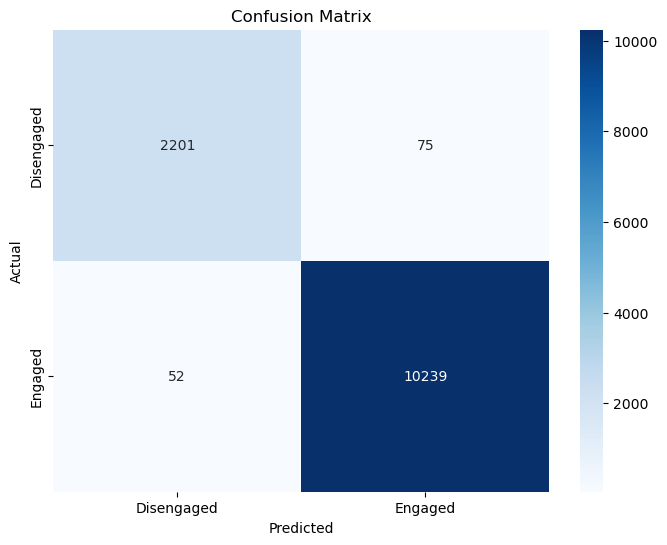

Classification Report:
              precision    recall  f1-score   support

  Disengaged       0.98      0.97      0.97      2276
     Engaged       0.99      0.99      0.99     10291

    accuracy                           0.99     12567
   macro avg       0.98      0.98      0.98     12567
weighted avg       0.99      0.99      0.99     12567



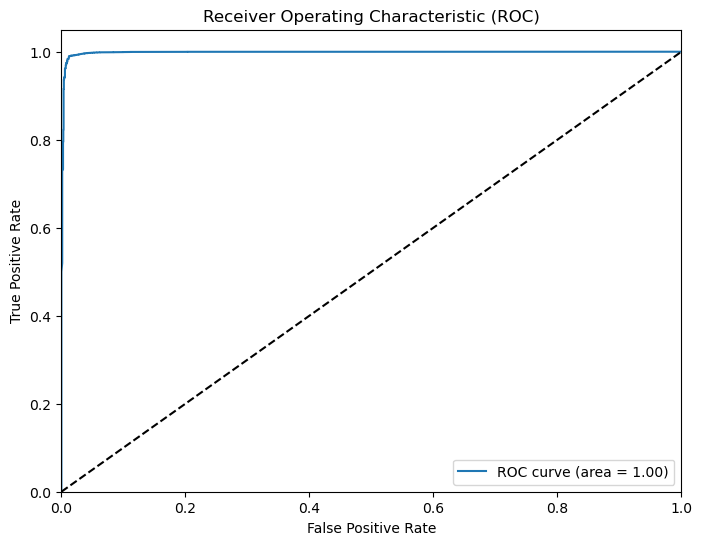

AUC Score: 1.00


In [63]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# --- Confusion Matrix --- #
cm = confusion_matrix(y_test, y_pred_classes)
class_labels = ['Disengaged', 'Engaged']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# --- Classification Report --- #
print("Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=class_labels))

# --- ROC Curve & AUC Score --- #
y_pred_prob = y_pred[:, 1]  # Ambil probabilitas untuk kelas positif (Engaged)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"AUC Score: {roc_auc:.2f}")

Train Ulang Model

In [64]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Training menggunakan ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 50678 images belonging to 2 classes.
Found 12567 images belonging to 2 classes.


In [65]:
#validasi dataset di train_generator

print(f"Total training samples: {train_generator.samples}")
print(f"Total testing samples: {test_generator.samples}")

Total training samples: 50678
Total testing samples: 12567


In [66]:
#ubah dataset dari rgb ke grayscale

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset Training dan Testing menggunakan ImageDataGenerator dalam mode Grayscale
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'  # Konversi gambar menjadi grayscale
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',  # Konversi gambar menjadi grayscale
    shuffle=False
)

Found 50678 images belonging to 2 classes.
Found 12567 images belonging to 2 classes.


In [67]:
#periksa bentukan datasetnya

batch_X, batch_y = next(train_generator)
print("Shape of a batch from train_generator:", batch_X.shape)

Shape of a batch from train_generator: (32, 48, 48, 1)


In [68]:
#sesuaikan arsitektur buat binary classfctn

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

# Arsitektur Model untuk Binary Classification
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48, 48, 1)),  # Sesuai dataset grayscale
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 1 neuron untuk klasifikasi biner
])

# Compile Model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',  # Sesuai dengan output sigmoid
    metrics=['accuracy']
)

# Tampilkan Ringkasan Model
model.summary()

C:\Users\RY\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 46, 46, 32)         │             320 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 23, 23, 32)         │             128 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 21, 21, 64)         │          18,496 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 64)         │             256 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)               │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                │         819,328 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                  │             129 │
└──────────────────────────────────────┴────────────────────────────┴─────────────────┘

 Total params: 838,657 (3.20 MB)

 Trainable params: 838,465 (3.20 MB)

 Non-trainable params: 192 (768.00 B)

In [69]:
#bismillaah retraining ya allah ya allah

from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Latih ulang model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

C:\Users\RY\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 211s 129ms/step - accuracy: 0.8707 - loss: 0.4030 - val_accuracy: 0.9320 - val_loss: 0.1839
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 147s 56ms/step - accuracy: 0.9293 - loss: 0.1877 - val_accuracy: 0.9388 - val_loss: 0.1496
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 88s 55ms/step - accuracy: 0.9426 - loss: 0.1391 - val_accuracy: 0.9523 - val_loss: 0.1228
Epoch 4/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 88s 56ms/step - accuracy: 0.9571 - loss: 0.1123 - val_accuracy: 0.9646 - val_loss: 0.0928
Epoch 5/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 93s 59ms/step - accuracy: 0.9635 - loss: 0.0937 - val_accuracy: 0.9709 - val_loss: 0.0792
Epoch 6/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 89s 56ms/step - accuracy: 0.9731 - loss: 0.0730 - val_accuracy: 0.9775 - val_loss: 0.0633
Epoch 7/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 142s 56ms/step - accuracy: 0.9735 - loss: 0.0715 - val_accuracy: 0.9620 - val_loss: 0.1078
Epoch 8/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 90s 57ms/step - accuracy: 0.97

In [70]:
#save model

model.save('baseline_retraining.h5')

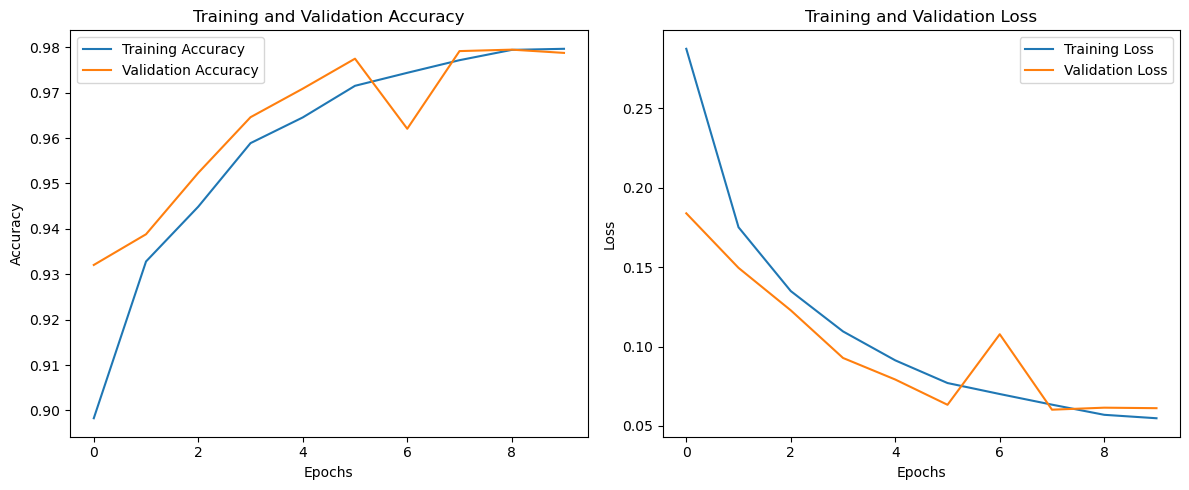

In [71]:
#visualisasikan kurva loss dan akurasi

import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Masih Kureng Yakin, Data Augmentasi Yok

In [72]:
# Simpan model saat ini sebagai backup
model.save('student_engagement_model_backup_31des.h5')
print("Model saat ini berhasil disimpan sebagai backup.")

Model saat ini berhasil disimpan sebagai backup.


In [73]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dataset Testing tetap tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset Training dengan Data Augmentation
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale'
)

# Load Dataset Testing
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(48, 48),
    batch_size=32,
    class_mode='binary',
    color_mode='grayscale',
    shuffle=False
)

Found 50678 images belonging to 2 classes.
Found 12567 images belonging to 2 classes.


In [74]:
from tensorflow.keras.layers import Dropout

# Tambahkan Dropout Layer utk mencegah overfitting
model.add(Dropout(0.5))  # Dropout tambahan untuk regularisasi
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
print("Dropout layer berhasil ditambahkan dan model di-compile ulang.")


Dropout layer berhasil ditambahkan dan model di-compile ulang.


In [78]:
from tensorflow.keras.optimizers import Adam

# Gunakan learning rate kecil untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate lebih kecil
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)
print("Learning rate berhasil disesuaikan untuk fine-tuning.")

Learning rate berhasil disesuaikan untuk fine-tuning.


In [79]:
#latih model finetuning-nya

from tensorflow.keras.callbacks import EarlyStopping

# Callback Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fine-tuning Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 132s 78ms/step - accuracy: 0.5010 - loss: 7.9357 - precision_3: 0.8171 - recall_3: 0.4956 - val_accuracy: 0.9347 - val_loss: 0.2765 - val_precision_3: 0.9271 - val_recall_3: 0.9987
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 136s 75ms/step - accuracy: 0.4965 - loss: 7.9707 - precision_3: 0.8141 - recall_3: 0.4902 - val_accuracy: 0.9196 - val_loss: 0.4157 - val_precision_3: 0.9111 - val_recall_3: 0.9992
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 121s 76ms/step - accuracy: 0.5002 - loss: 7.8764 - precision_3: 0.8201 - recall_3: 0.4928 - val_accuracy: 0.8958 - val_loss: 0.7240 - val_precision_3: 0.8874 - val_recall_3: 0.9996
Epoch 4/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 141s 89ms/step - accuracy: 0.4971 - loss: 7.8702 - precision_3: 0.8191 - recall_3: 0.4871 - val_accuracy: 0.8613 - val_loss: 1.4808 - val_precision_3: 0.8553 - val_recall_3: 0.9998
Epoch 5/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 128s 80ms/step - accuracy: 0.4911 - loss: 7.8297 - precision_3: 0.

In [80]:
# Evaluasi Model setelah finetuning
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.8447 - loss: 0.6644 - precision_3: 0.6525 - recall_3: 0.8192
✅ Test Loss: 0.27650073170661926
✅ Test Accuracy: 0.9346701502799988
✅ Precision: 0.927115261554718
✅ Recall: 0.9987367391586304
✅ F1-Score: 0.9615941668691838


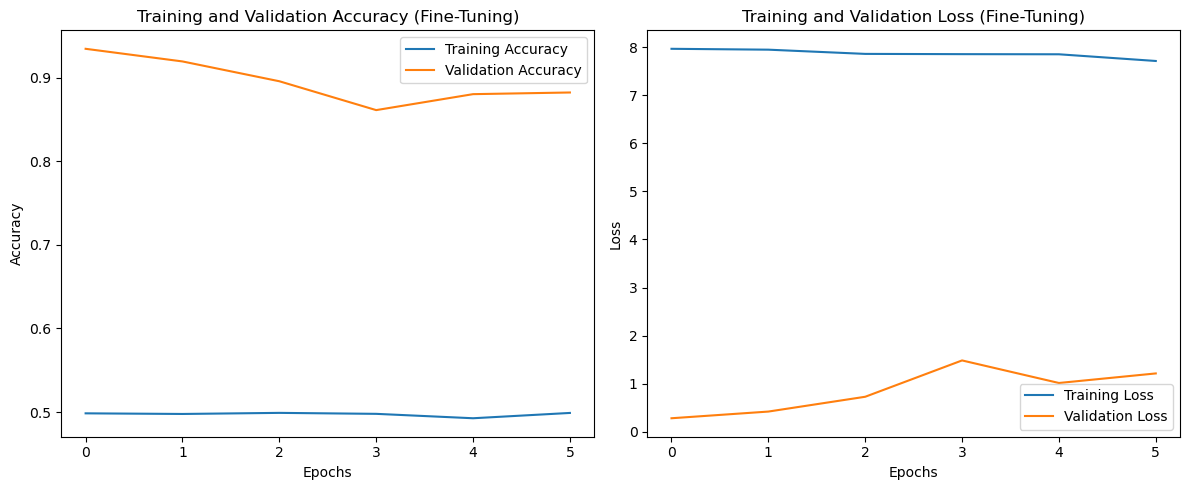

In [81]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Fine-Tuning)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
# Simpan Model Fine-Tuning
model.save('model_finetuned.h5')
print("Model hasil fine-tuning berhasil disimpan.")

Model hasil fine-tuning berhasil disimpan.


Kalo diliat dari kurva akurasi
1. Training Accuracy stagnan: model tidak berhasil belajar dari data augmentasi dan justru stagnan di sekitar 50%
2. Validation Accuracy yang menurun: performa di dataset validasi semakin menurun seiring dengan epoch

Kemungkinan besar: Terjadi "Catastrophic Forgetting" – model kehilangan kemampuan awalnya setelah fine-tuning

Kalo diliat dari kurva loss
1. Training loss stagnan: model tidak dapat mempelajari pola baru dengan data augmentasi yang kita berikan
2. Validation Loss yang meningkat: model semakin buruk dalam memprediksi data validasi

Opsinya:
1. Freeze Layer Awal (Feature Extraction Layer)
2. Ubah Learning Rate Secara Bertahap (Learning Rate Scheduler)
3. Pake model pre-trained yang sudah di-tune untuk tugas serupa
4. Alternatif arsitektur lain dgn dense lebih dalam

YOOOOOK COBA SATU-SATU

In [83]:
#Opsi 1: Freeze Layer Awal

# Simpan model saat ini sebagai backup
model.save('model_before_freeze.h5')
print("Model saat ini berhasil disimpan sebagai backup sebelum freeze.")

Model saat ini berhasil disimpan sebagai backup sebelum freeze.


In [84]:
# Freeze semua layer awal model kecuali beberapa layer terakhir
for layer in model.layers[:-4]:  # Freeze semua kecuali 4 layer terakhir
    layer.trainable = False

# Tampilkan status layer apakah trainable atau tidak
for layer in model.layers:
    print(f"{layer.name}: Trainable = {layer.trainable}")

conv2d_7: Trainable = False
max_pooling2d_3: Trainable = False
batch_normalization_3: Trainable = False
conv2d_8: Trainable = False
max_pooling2d_4: Trainable = False
batch_normalization_4: Trainable = False
flatten_1: Trainable = False
dense_6: Trainable = True
dropout_6: Trainable = True
dense_7: Trainable = True
dropout_7: Trainable = True


In [85]:
from tensorflow.keras.optimizers import Adam

# Compile ulang model dengan learning rate yang kecil
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Learning rate kecil untuk fine-tuning
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("✅ Model berhasil di-compile ulang dengan layer awal dibekukan.")

✅ Model berhasil di-compile ulang dengan layer awal dibekukan.


In [86]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fine-Tuning Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 151s 93ms/step - accuracy: 0.4963 - loss: 7.9716 - precision_4: 0.8127 - recall_4: 0.4918 - val_accuracy: 0.9195 - val_loss: 0.3945 - val_precision_4: 0.9115 - val_recall_4: 0.9986
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 148s 94ms/step - accuracy: 0.5000 - loss: 7.9235 - precision_4: 0.8177 - recall_4: 0.4936 - val_accuracy: 0.9087 - val_loss: 0.4949 - val_precision_4: 0.9008 - val_recall_4: 0.9985
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 145s 91ms/step - accuracy: 0.4986 - loss: 7.8889 - precision_4: 0.8228 - recall_4: 0.4892 - val_accuracy: 0.9099 - val_loss: 0.5098 - val_precision_4: 0.9019 - val_recall_4: 0.9986
Epoch 4/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 136s 86ms/step - accuracy: 0.4923 - loss: 7.9987 - precision_4: 0.8086 - recall_4: 0.4871 - val_accuracy: 0.9046 - val_loss: 0.5650 - val_precision_4: 0.8966 - val_recall_4: 0.9986
Epoch 5/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 145s 88ms/step - accuracy: 0.4951 - loss: 7.9340 - precision_4: 0.

In [87]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

393/393 ━━━━━━━━━━━━━━━━━━━━ 24s 60ms/step - accuracy: 0.8013 - loss: 0.9693 - precision_4: 0.6283 - recall_4: 0.8192
✅ Test Loss: 0.3944569230079651
✅ Test Accuracy: 0.9194716215133667
✅ Precision: 0.9114856123924255
✅ Recall: 0.9986395835876465
✅ F1-Score: 0.9530742452564213


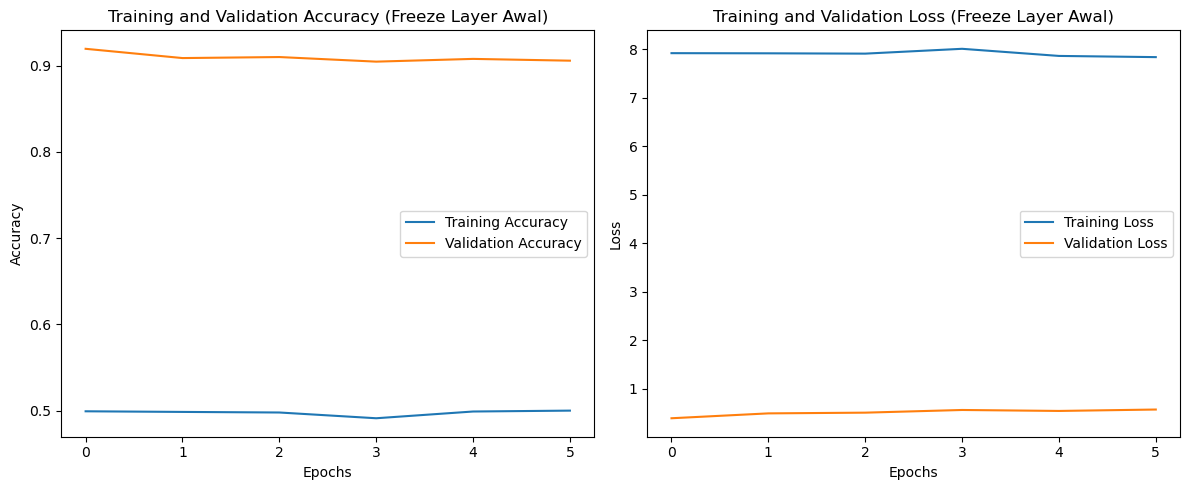

In [88]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Freeze Layer Awal)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Freeze Layer Awal)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [89]:
# Simpan Model Fine-Tuning
model.save('model_finetuned_freeze_layers.h5')
print("✅ Model hasil fine-tuning berhasil disimpan.")

✅ Model hasil fine-tuning berhasil disimpan.


Catatan Opsi 1: Freeze Layer
1. Training Stagnan: Model tidak berhasil mempelajari pola baru dengan freeze layer awal.
2. Validation Menurun: Akurasi validasi menurun seiring epoch, dan loss meningkat.

In [90]:
#Opsi 2: Learning Rate Scheduler

from tensorflow.keras.models import load_model

# Muat model backup sebelum freeze
model = load_model('model_before_freeze.h5')
print("✅ Model berhasil dimuat ulang dari backup sebelum freeze.")

✅ Model berhasil dimuat ulang dari backup sebelum freeze.


In [91]:
# Periksa status trainable setiap layer
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name} | Trainable = {layer.trainable}")

Layer 0: conv2d_7 | Trainable = True
Layer 1: max_pooling2d_3 | Trainable = True
Layer 2: batch_normalization_3 | Trainable = True
Layer 3: conv2d_8 | Trainable = True
Layer 4: max_pooling2d_4 | Trainable = True
Layer 5: batch_normalization_4 | Trainable = True
Layer 6: flatten_1 | Trainable = True
Layer 7: dense_6 | Trainable = True
Layer 8: dropout_6 | Trainable = True
Layer 9: dense_7 | Trainable = True
Layer 10: dropout_7 | Trainable = True


In [92]:
from tensorflow.keras.optimizers import Adam

# Compile ulang model
model.compile(
    optimizer=Adam(learning_rate=0.001),  # Learning rate awal
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("✅ Model berhasil di-compile ulang dengan konfigurasi awal.")

✅ Model berhasil di-compile ulang dengan konfigurasi awal.


In [93]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Fungsi Scheduler: Menyesuaikan Learning Rate berdasarkan Epoch
def scheduler(epoch, lr):
    if epoch < 3:
        return lr  # Pertahankan learning rate awal selama 3 epoch pertama
    else:
        return lr * 0.1  # Turunkan learning rate 10x lipat setelah epoch ke-3

# Inisialisasi Callback Scheduler
lr_scheduler = LearningRateScheduler(scheduler, verbose=1)

print("✅ Learning Rate Scheduler berhasil diinisialisasi.")

✅ Learning Rate Scheduler berhasil diinisialisasi.


In [94]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

# Compile Model dengan Learning Rate Awal
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

print("✅ Model berhasil di-compile ulang dengan learning rate awal 0.001.")


✅ Model berhasil di-compile ulang dengan learning rate awal 0.001.


In [95]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Fine-Tuning Model dengan Scheduler
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, lr_scheduler],
    verbose=1
)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 158s 95ms/step - accuracy: 0.4965 - loss: 8.0180 - precision_6: 0.8137 - recall_6: 0.4933 - val_accuracy: 0.8198 - val_loss: 29.3497 - val_precision_6: 0.8196 - val_recall_6: 1.0000 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 146s 92ms/step - accuracy: 0.4968 - loss: 8.0856 - precision_6: 0.8123 - recall_6: 0.4957 - val_accuracy: 0.8224 - val_loss: 16.1209 - val_precision_6: 0.8218 - val_recall_6: 1.0000 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 193s 87ms/step - accuracy: 0.4952 - loss: 8.1174 - precision_6: 0.8151 - recall_6: 0.4928 - val_accuracy: 0.8189 - val_loss: 15.1321 - val_precision_6: 0.8189 - val_recall_6: 1.0000 - learning_rate: 0.0010

Epoch 4: Learni

In [96]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

393/393 ━━━━━━━━━━━━━━━━━━━━ 24s 62ms/step - accuracy: 0.5128 - loss: 38.2845 - precision_6: 0.5118 - recall_6: 0.8198
✅ Test Loss: 14.385273933410645
✅ Test Accuracy: 0.8192886114120483
✅ Precision: 0.8192166686058044
✅ Recall: 1.0
✅ F1-Score: 0.9006256788558832


In [97]:
from sklearn.metrics import f1_score

# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - accuracy: 0.5128 - loss: 38.2845 - precision_6: 0.5118 - recall_6: 0.8198
✅ Test Loss: 14.385273933410645
✅ Test Accuracy: 0.8192886114120483
✅ Precision: 0.8192166686058044
✅ Recall: 1.0
✅ F1-Score: 0.9006256788558832


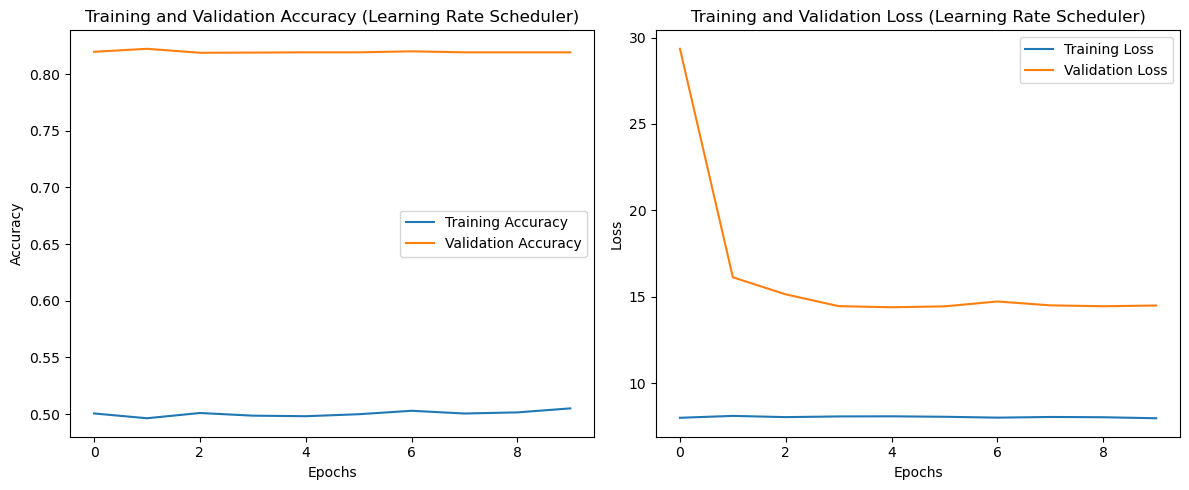

In [98]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (Learning Rate Scheduler)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (Learning Rate Scheduler)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [99]:
# Simpan Model Fine-Tuning dengan Scheduler
model.save('model_finetuned_scheduler.h5')
print("✅ Model hasil fine-tuning dengan scheduler berhasil disimpan.")

✅ Model hasil fine-tuning dengan scheduler berhasil disimpan.


Catatan Opsi 2: Scheduler
1. Training Tidak Efektif: Model gagal meningkatkan akurasi atau menurunkan loss meskipun learning rate diatur secara bertahap
2. Stagnasi pada Validation Metrics: Tidak ada peningkatan akurasi atau penurunan loss pada validasi

In [100]:
#Opsi 3: Pake Model Pretrained

from tensorflow.keras.models import load_model

# Muat model backup sebelum freeze
model = load_model('model_before_freeze.h5')
print("✅ Model berhasil dimuat ulang dari backup sebelum freeze.")

✅ Model berhasil dimuat ulang dari backup sebelum freeze.


In [101]:
# Pastikan dataset sesuai dengan input MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk Training Data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dataset Testing tetap tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset Training dan Testing
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resolusi input MobileNetV2
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'  # MobileNetV2 membutuhkan 3 channel
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("✅ Dataset siap untuk digunakan dengan MobileNetV2.")

Found 50678 images belonging to 2 classes.
Found 12567 images belonging to 2 classes.
✅ Dataset siap untuk digunakan dengan MobileNetV2.


In [102]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D

# Load MobileNetV2 sebagai Feature Extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer awal MobileNetV2
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan Layer Kustom di Atas MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling untuk mengurangi dimensi
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularisasi untuk mencegah overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Output biner

# Bangun Model Akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Tampilkan Ringkasan Model
model.summary()
print("✅ Model MobileNetV2 berhasil disiapkan dan di-compile.")

Model: "functional_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape        ┃      Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5           │ (None, 224, 224, 3) │            0 │ -                    │
│ (InputLayer)            │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ Conv1 (Conv2D)          │ (None, 112, 112,    │          864 │ input_layer_5[0][0]  │
│                         │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ bn_Conv1                │ (None, 112, 112,    │          128 │ Conv1[0][0]          │
│ (BatchNormalization)    │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ Conv1_relu (ReLU)       │ (None, 112, 112,    │            0 │ bn_Conv1[0][0]       │
│                         │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ expanded_conv_depthwise │ (None, 112, 112,    │          288 │ Conv1_relu[0][0]     │
│ (DepthwiseConv2D)       │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ expanded_conv_depthwis… │ (None, 112, 112,    │          128 │ expanded_conv_depth… │
│ (BatchNormalization)    │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ expanded_conv_depthwis… │ (None, 112, 112,    │            0 │ expanded_conv_depth… │
│ (ReLU)                  │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ expanded_conv_project   │ (None, 112, 112,    │          512 │ expanded_conv_depth… │
│ (Conv2D)                │ 16)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ expanded_conv_project_… │ (None, 112, 112,    │           64 │ expanded_conv_proje… │
│ (BatchNormalization)    │ 16)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block_1_expand (Conv2D) │ (None, 112, 112,    │        1,536 │ expanded_conv_proje… │
│                         │ 96)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block_1_expand_BN       │ (None, 112, 112,    │          384 │ block_1_expand[0][0] │
│ (BatchNormalization)    │ 96)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block_1_expand_relu     │ (None, 112, 112,    │            0 │ block_1_expand_BN[0… │
│ (ReLU)                  │ 96)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block_1_pad             │ (None, 113, 113,    │            0 │ block_1_expand_relu… │
│ (ZeroPadding2D)         │ 96)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block_1_depthwise       │ (None, 56, 56, 96)  │          864 │ block_1_pad[0][0]    │
│ (DepthwiseConv2D)       │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block_1_depthwise_BN    │ (None, 56, 5

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

✅ Model MobileNetV2 berhasil disiapkan dan di-compile.


In [103]:
from tensorflow.keras.callbacks import EarlyStopping

# Callback untuk EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Latih Model dengan MobileNetV2
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1974s 1s/step - accuracy: 0.8370 - loss: 0.4118 - precision_7: 0.8497 - recall_7: 0.9711 - val_accuracy: 0.8945 - val_loss: 0.2715 - val_precision_7: 0.8885 - val_recall_7: 0.9961
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1608s 1s/step - accuracy: 0.8840 - loss: 0.3094 - precision_7: 0.8896 - recall_7: 0.9783 - val_accuracy: 0.9196 - val_loss: 0.2375 - val_precision_7: 0.9219 - val_recall_7: 0.9853
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1613s 1s/step - accuracy: 0.8973 - loss: 0.2754 - precision_7: 0.9041 - recall_7: 0.9780 - val_accuracy: 0.9183 - val_loss: 0.2256 - val_precision_7: 0.9194 - val_recall_7: 0.9867
Epoch 4/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1653s 1s/step - accuracy: 0.9031 - loss: 0.2596 - precision_7: 0.9092 - recall_7: 0.9788 - val_accuracy: 0.9223 - val_loss: 0.2153 - val_precision_7: 0.9253 - val_recall_7: 0.9845
Epoch 5/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1641s 1s/step - accuracy: 0.9106 - loss: 0.2467 - precision_7: 0.9158 

In [104]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

393/393 ━━━━━━━━━━━━━━━━━━━━ 362s 920ms/step - accuracy: 0.8363 - loss: 0.3614 - precision_7: 0.6490 - recall_7: 0.8126
✅ Test Loss: 0.19230151176452637
✅ Test Accuracy: 0.928145170211792
✅ Precision: 0.9251811504364014
✅ Recall: 0.9925177097320557
✅ F1-Score: 0.9576671788336816


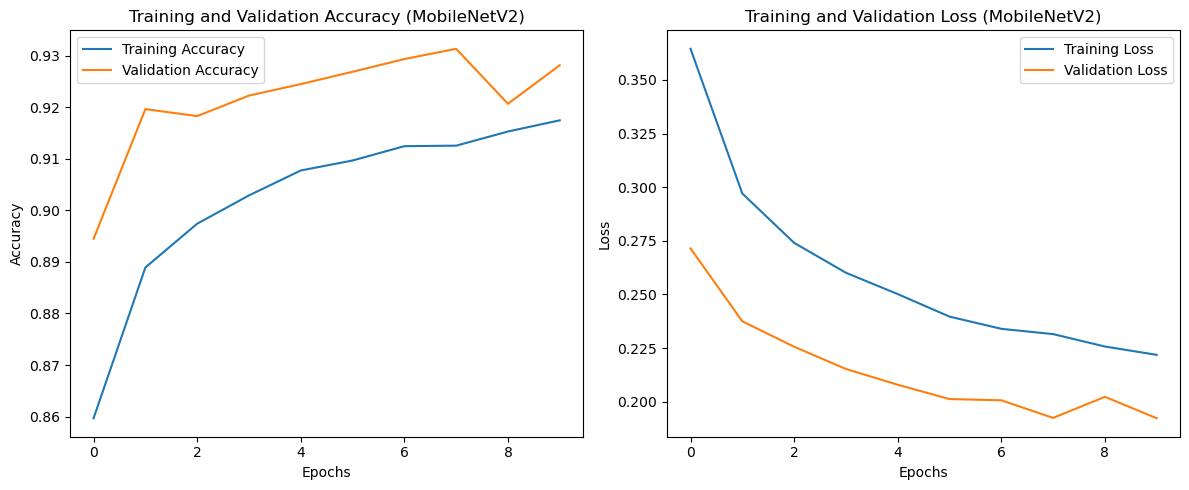

In [105]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (MobileNetV2)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [106]:
# Simpan Model
model.save('model_mobilenetv2.h5')
print("✅ Model MobileNetV2 berhasil disimpan.")

✅ Model MobileNetV2 berhasil disimpan.


Performa Model Menggunakan MobileNetV2

Training Accuracy	~92%
Validation Accuracy	~93%
Training Loss	~0.22
Validation Loss	~0.19

Poin Penting:
Model Pre-trained MobileNetV2 bekerja sangat baik untuk tugas klasifikasi ini
Akurasi yang tinggi dan loss yang rendah menunjukkan bahwa model dapat melakukan prediksi dengan baik pada data baru
Tidak ada tanda overfitting atau underfitting, menandakan proses pelatihan berjalan optimal

In [107]:
#Opsi 4: Pake model Resnet50

from tensorflow.keras.models import load_model

# Muat model dari path yang ditentukan
model_path = r"C:\Users\RY\Exp5\labelled\model_before_freeze.h5"
model = load_model(model_path)

print("✅ Model berhasil dimuat dari path yang ditentukan.")

✅ Model berhasil dimuat dari path yang ditentukan.


In [108]:
# Tampilkan ringkasan model sebelum freeze layer tadi
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape               ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 46, 46, 32)         │             320 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 23, 23, 32)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 23, 23, 32)         │             128 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 21, 21, 64)         │          18,496 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 10, 10, 64)         │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 10, 10, 64)         │             256 │
│ (BatchNormalization)                 │                            │                 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6400)               │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                │         819,328 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                │               0 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                  │             129 │
├──────────────────────────────────────┼────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 1)                  │               0 │
└──────────────────────────────────────┴────────────────────────────┴─────────────────┘

 Total params: 838,659 (3.20 MB)

 Trainable params: 838,465 (3.20 MB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 2 (12.00 B)

In [109]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation untuk Training Data pake resnet50
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Dataset Testing tetap tanpa augmentasi
test_datagen = ImageDataGenerator(rescale=1./255)

# Load Dataset Training dan Testing
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

print("✅ Dataset siap untuk digunakan dengan ResNet50.")


Found 50678 images belonging to 2 classes.
Found 12567 images belonging to 2 classes.
✅ Dataset siap untuk digunakan dengan ResNet50.


In [110]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load ResNet50 sebagai Feature Extractor
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer awal untuk mempertahankan fitur pretrained
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan Layer Kustom
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Mengurangi dimensi fitur
x = Dense(128, activation='relu')(x)  # Layer Dense untuk klasifikasi
x = Dropout(0.5)(x)  # Dropout untuk mencegah overfitting
predictions = Dense(1, activation='sigmoid')(x)  # Output untuk klasifikasi biner

# Bangun Model Akhir
model = Model(inputs=base_model.input, outputs=predictions)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Tampilkan Ringkasan Model
model.summary()
print("✅ Model ResNet50 berhasil disiapkan dan di-compile ulang.")

Model: "functional_84"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape        ┃      Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6           │ (None, 224, 224, 3) │            0 │ -                    │
│ (InputLayer)            │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv1_pad               │ (None, 230, 230, 3) │            0 │ input_layer_6[0][0]  │
│ (ZeroPadding2D)         │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv1_conv (Conv2D)     │ (None, 112, 112,    │        9,472 │ conv1_pad[0][0]      │
│                         │ 64)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv1_bn                │ (None, 112, 112,    │          256 │ conv1_conv[0][0]     │
│ (BatchNormalization)    │ 64)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv1_relu (Activation) │ (None, 112, 112,    │            0 │ conv1_bn[0][0]       │
│                         │ 64)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ pool1_pad               │ (None, 114, 114,    │            0 │ conv1_relu[0][0]     │
│ (ZeroPadding2D)         │ 64)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ pool1_pool              │ (None, 56, 56, 64)  │            0 │ pool1_pad[0][0]      │
│ (MaxPooling2D)          │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_1_conv     │ (None, 56, 56, 64)  │        4,160 │ pool1_pool[0][0]     │
│ (Conv2D)                │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_1_bn       │ (None, 56, 56, 64)  │          256 │ conv2_block1_1_conv… │
│ (BatchNormalization)    │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_1_relu     │ (None, 56, 56, 64)  │            0 │ conv2_block1_1_bn[0… │
│ (Activation)            │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_2_conv     │ (None, 56, 56, 64)  │       36,928 │ conv2_block1_1_relu… │
│ (Conv2D)                │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_2_bn       │ (None, 56, 56, 64)  │          256 │ conv2_block1_2_conv… │
│ (BatchNormalization)    │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_2_relu     │ (None, 56, 56, 64)  │            0 │ conv2_block1_2_bn[0… │
│ (Activation)            │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_0_conv     │ (None, 56, 56, 256) │       16,640 │ pool1_pool[0][0]     │
│ (Conv2D)                │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ conv2_block1_3_conv     │ (None, 56, 5

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

✅ Model ResNet50 berhasil disiapkan dan di-compile ulang.


In [111]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback untuk EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Callback untuk ModelCheckpoint (Format .keras)
checkpoint = ModelCheckpoint(
    'checkpoint_resnet50.keras',  # Ubah ekstensi ke .keras
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("✅ Callback EarlyStopping dan ModelCheckpoint (.keras format) telah diatur.")

✅ Callback EarlyStopping dan ModelCheckpoint (.keras format) telah diatur.


In [112]:
# Latih Model ResNet50
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8103 - loss: 0.4928 - precision_8: 0.8131 - recall_8: 0.9955
Epoch 1: val_loss improved from inf to 0.45920, saving model to checkpoint_resnet50.keras
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 4625s 3s/step - accuracy: 0.8103 - loss: 0.4928 - precision_8: 0.8131 - recall_8: 0.9955 - val_accuracy: 0.8189 - val_loss: 0.4592 - val_precision_8: 0.8189 - val_recall_8: 1.0000
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8127 - loss: 0.4760 - precision_8: 0.8127 - recall_8: 1.0000
Epoch 2: val_loss improved from 0.45920 to 0.44836, saving model to checkpoint_resnet50.keras
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 4598s 3s/step - accuracy: 0.8127 - loss: 0.4760 - precision_8: 0.8127 - recall_8: 1.0000 - val_accuracy: 0.8189 - val_loss: 0.4484 - val_precision_8: 0.8189 - val_recall_8: 1.0000
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8142 - loss: 0.4677 - precision_8: 0.8142 - recall_8: 1.0000
Epoch 3: v

In [113]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

393/393 ━━━━━━━━━━━━━━━━━━━━ 836s 2s/step - accuracy: 0.5115 - loss: 0.8166 - precision_8: 0.5115 - recall_8: 0.8198
✅ Test Loss: 0.42684996128082275
✅ Test Accuracy: 0.8188907504081726
✅ Precision: 0.8188907504081726
✅ Recall: 1.0
✅ F1-Score: 0.9004286873227246


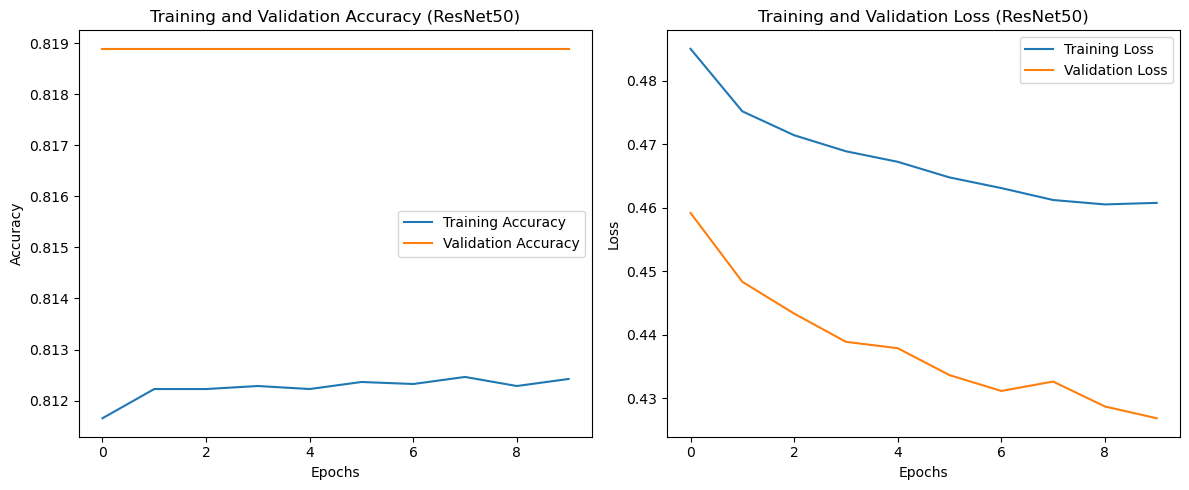

In [114]:
import matplotlib.pyplot as plt

# Plot Training & Validation Accuracy
plt.figure(figsize=(12, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss (ResNet50)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [115]:
model.save('model_resnet50.keras')
print("✅ Model berhasil disimpan sebagai 'student_engagement_resnet50_final.keras'")

✅ Model berhasil disimpan sebagai 'student_engagement_resnet50_final.keras'


In [116]:
#Opsi 5: Pake model EfficientNet

from tensorflow.keras.models import load_model

# Muat model dari path yang ditentukan
model_path = r"C:\Users\RY\Exp5\labelled\model_before_freeze.h5"
model = load_model(model_path)

print("✅ Model berhasil dimuat dari path yang ditentukan.")

✅ Model berhasil dimuat dari path yang ditentukan.


In [117]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load EfficientNetB0 sebagai Feature Extractor
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer awal
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan layer tambahan
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Bangun model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Tampilkan ringkasan model
model.summary()
print("✅ EfficientNetB0 berhasil diinisialisasi dan di-compile ulang.")

Model: "functional_96"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape        ┃      Param # ┃ Connected to         ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7           │ (None, 224, 224, 3) │            0 │ -                    │
│ (InputLayer)            │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ rescaling_2 (Rescaling) │ (None, 224, 224, 3) │            0 │ input_layer_7[0][0]  │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ normalization_1         │ (None, 224, 224, 3) │            7 │ rescaling_2[0][0]    │
│ (Normalization)         │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ rescaling_3 (Rescaling) │ (None, 224, 224, 3) │            0 │ normalization_1[0][… │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ stem_conv_pad           │ (None, 225, 225, 3) │            0 │ rescaling_3[0][0]    │
│ (ZeroPadding2D)         │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ stem_conv (Conv2D)      │ (None, 112, 112,    │          864 │ stem_conv_pad[0][0]  │
│                         │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ stem_bn                 │ (None, 112, 112,    │          128 │ stem_conv[0][0]      │
│ (BatchNormalization)    │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ stem_activation         │ (None, 112, 112,    │            0 │ stem_bn[0][0]        │
│ (Activation)            │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_dwconv          │ (None, 112, 112,    │          288 │ stem_activation[0][… │
│ (DepthwiseConv2D)       │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_bn              │ (None, 112, 112,    │          128 │ block1a_dwconv[0][0] │
│ (BatchNormalization)    │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_activation      │ (None, 112, 112,    │            0 │ block1a_bn[0][0]     │
│ (Activation)            │ 32)                 │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_se_squeeze      │ (None, 32)          │            0 │ block1a_activation[… │
│ (GlobalAveragePooling2… │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_se_reshape      │ (None, 1, 1, 32)    │            0 │ block1a_se_squeeze[… │
│ (Reshape)               │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_se_reduce       │ (None, 1, 1, 8)     │          264 │ block1a_se_reshape[… │
│ (Conv2D)                │                     │              │                      │
├─────────────────────────┼─────────────────────┼──────────────┼──────────────────────┤
│ block1a_se_expand       │ (None, 1, 1, 32)    │          288 │ block1a_se_reduce[0… │
│ (Conv2D)                │                     │              │                      │
├─────────────────────────┼─────────────

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

✅ EfficientNetB0 berhasil diinisialisasi dan di-compile ulang.


In [118]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callback untuk EarlyStopping dan ModelCheckpoint
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'checkpoint_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Latih Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8112 - loss: 0.4921 - precision_9: 0.8118 - recall_9: 0.9989
Epoch 1: val_loss improved from inf to 0.47528, saving model to checkpoint_model.keras
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 2159s 1s/step - accuracy: 0.8112 - loss: 0.4921 - precision_9: 0.8118 - recall_9: 0.9989 - val_accuracy: 0.8189 - val_loss: 0.4753 - val_precision_9: 0.8189 - val_recall_9: 1.0000
Epoch 2/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.8111 - loss: 0.4915 - precision_9: 0.8111 - recall_9: 1.0000
Epoch 2: val_loss improved from 0.47528 to 0.47344, saving model to checkpoint_model.keras
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 1910s 1s/step - accuracy: 0.8112 - loss: 0.4915 - precision_9: 0.8112 - recall_9: 1.0000 - val_accuracy: 0.8189 - val_loss: 0.4734 - val_precision_9: 0.8189 - val_recall_9: 1.0000
Epoch 3/10
1584/1584 ━━━━━━━━━━━━━━━━━━━━ 0s 937ms/step - accuracy: 0.8121 - loss: 0.4897 - precision_9: 0.8121 - recall_9: 1.0000
Epoch 3: v

393/393 ━━━━━━━━━━━━━━━━━━━━ 280s 713ms/step - accuracy: 0.5115 - loss: 0.9331 - precision_9: 0.5115 - recall_9: 0.8198
✅ Test Loss: 0.47270509600639343
✅ Test Accuracy: 0.8188907504081726
✅ Precision: 0.8188907504081726
✅ Recall: 1.0
✅ F1-Score: 0.9004286873227246


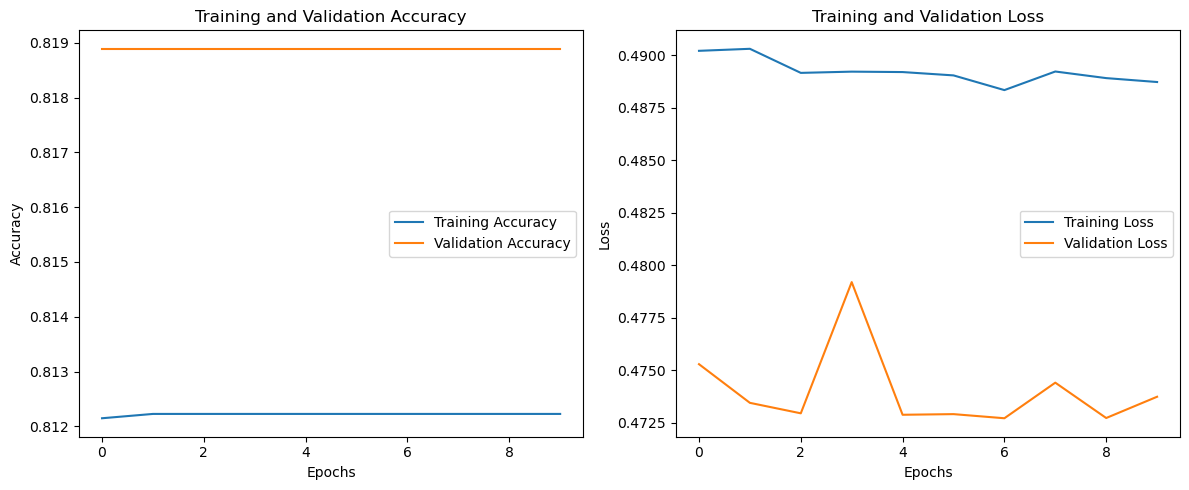

In [119]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(test_generator)
f1 = 2 * (precision * recall) / (precision + recall + 1e-7)  # Menghindari divisi dengan nol

print(f"✅ Test Loss: {loss}")
print(f"✅ Test Accuracy: {accuracy}")
print(f"✅ Precision: {precision}")
print(f"✅ Recall: {recall}")
print(f"✅ F1-Score: {f1}")

# Visualisasi Kurva Akurasi dan Loss
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [120]:
model.save('model_efficientnet.keras')
print("✅ Model berhasil disimpan sebagai 'model_efficientnet.keras'")

✅ Model berhasil disimpan sebagai 'model_efficientnet.keras'


In [121]:
import tensorflow as tf

model = tf.keras.models.load_model(r"C:\Users\RY\Exp5\labelled\model_mobilenetv2.h5")
model.save('model_mobilenetv2_final.keras')